<a href="https://colab.research.google.com/github/sairams18/Disease-outbreak-prediction/blob/main/Disease_Outbreak_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using 'outbreak_risk_category' as the target variable.
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00       105
           2       1.00      1.00      1.00      1699

    accuracy                           1.00      1805
   macro avg       1.00      1.00      1.00      1805
weighted avg       1.00      1.00      1.00      1805

Feature Importance: risk_score                        0.391563
air_quality_index                 0.135012
outbreak_frequency_5years         0.118816
public_transport_usage            0.087820
avg_humidity                      0.082273
international_travel_freq         0.074961
healthcare_accessibility_score    0.021300
daily_commuter_percentage         0.020884
vaccination_rate                  0.016028
median_income                     0.014433
region_id                         0.009860
risk_cluster                  

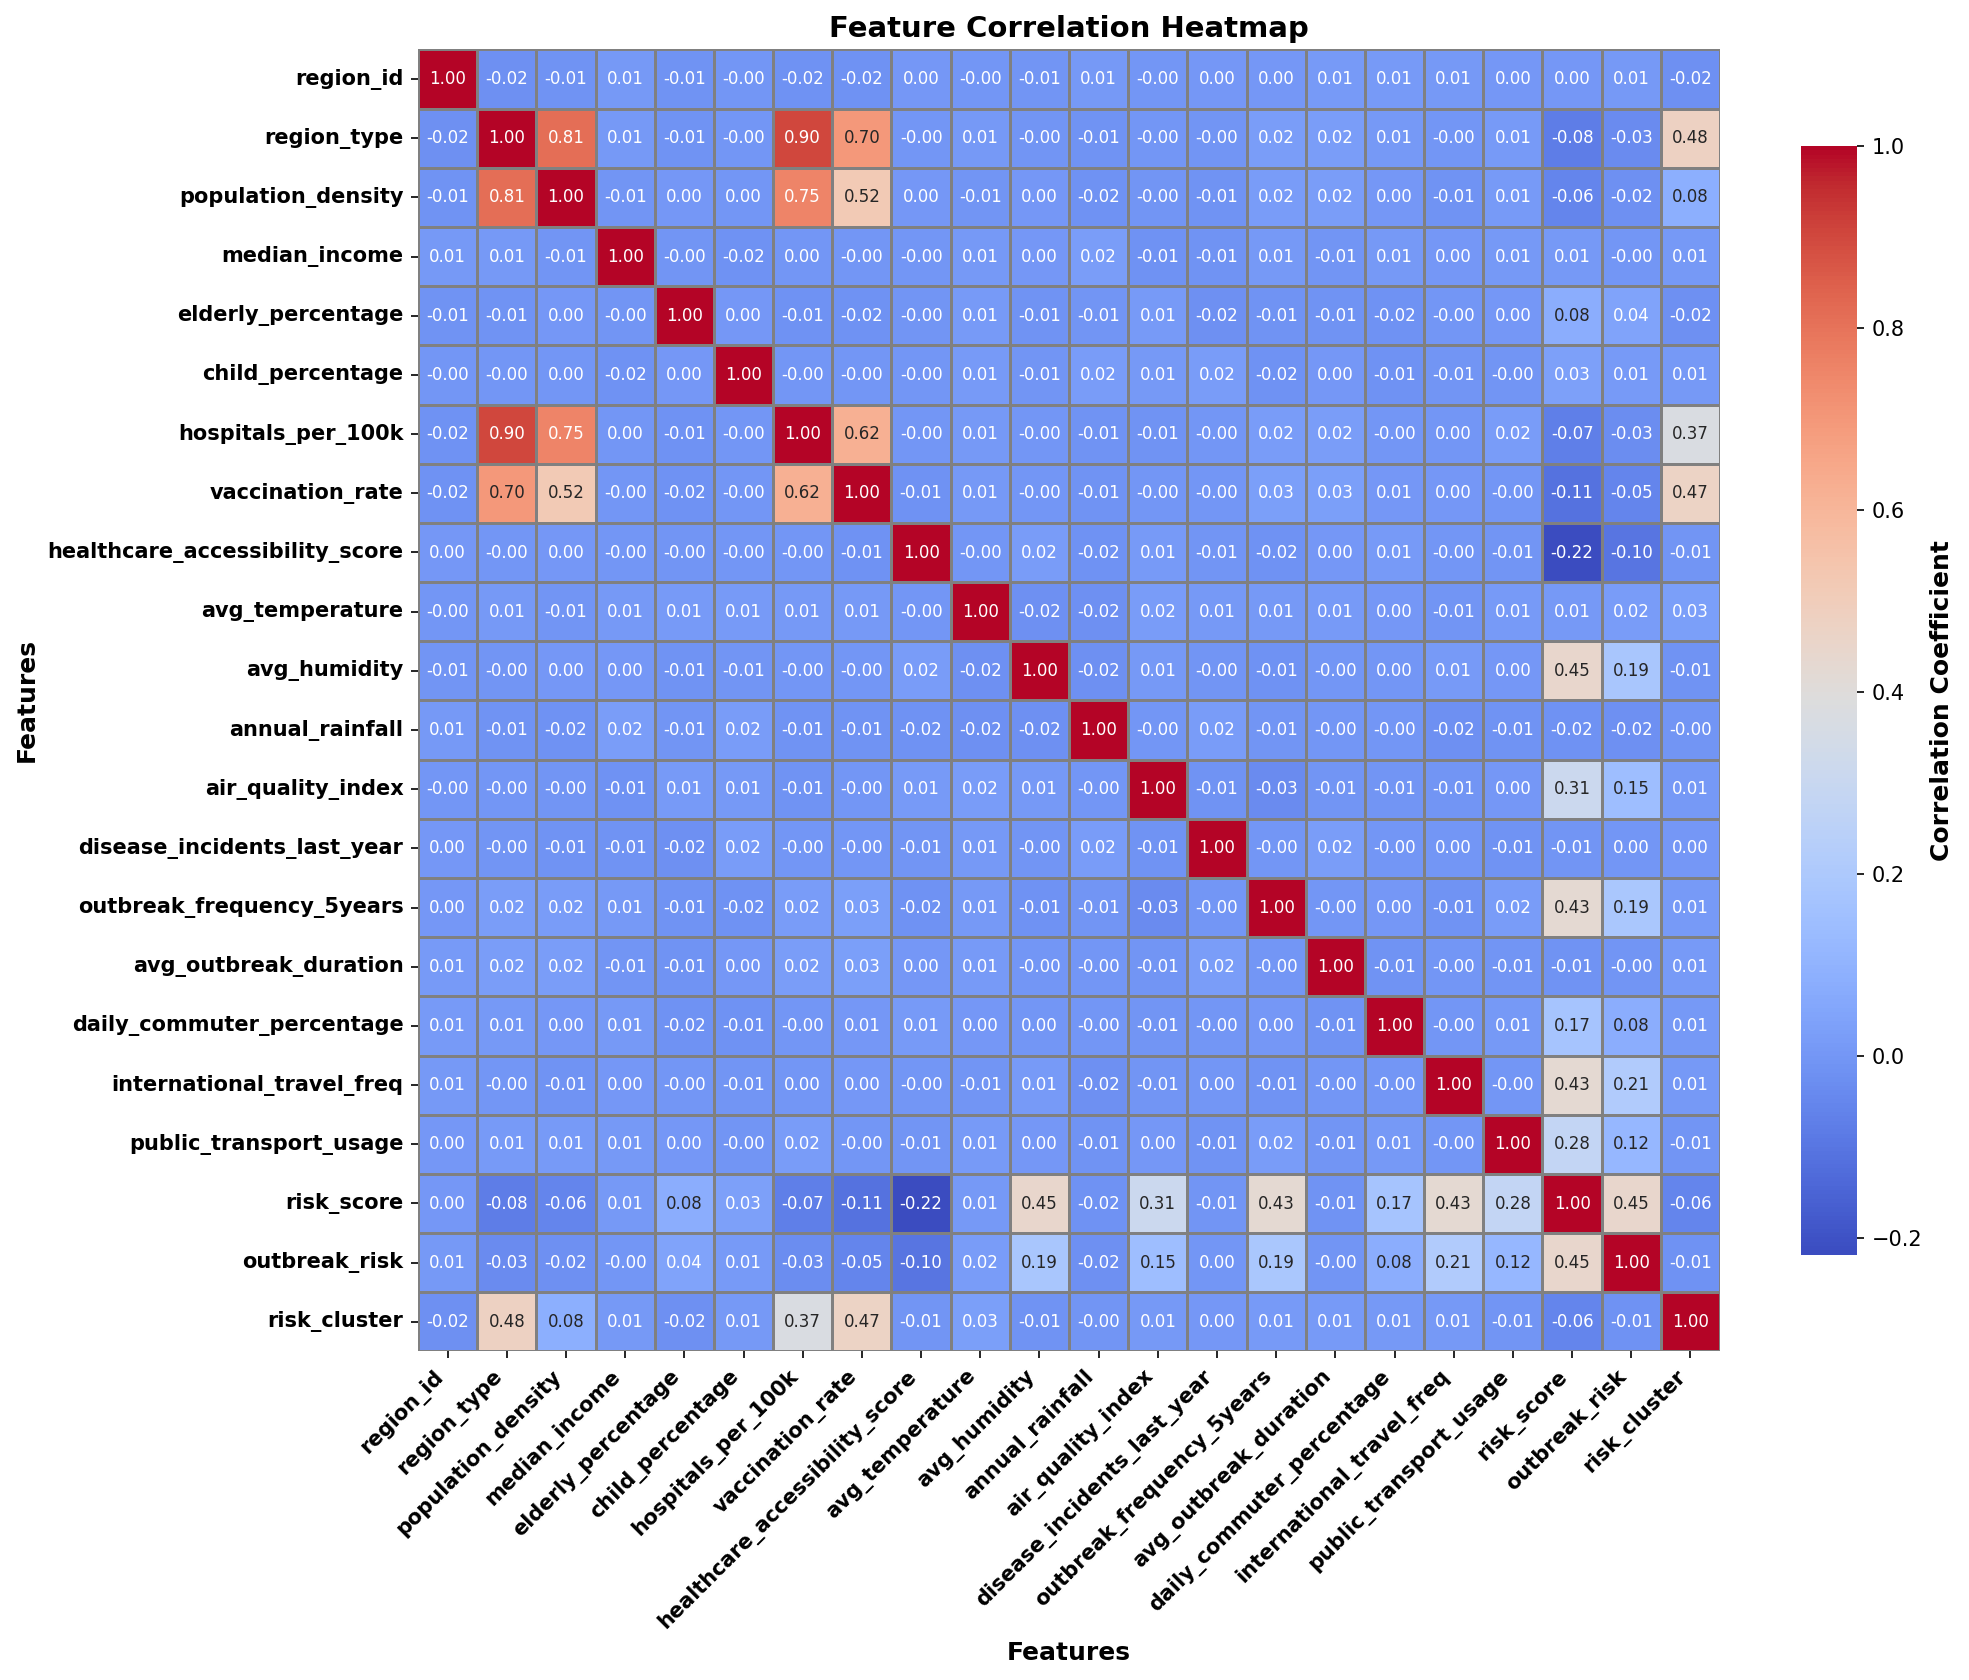


Heatmap Legend:
- Red (1.0): Strong Positive Correlation
- Blue (-1.0): Strong Negative Correlation
- White/Light Colors (0.0): No Correlation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Project Overview: Disease Outbreak Prediction
# This project analyzes environmental, demographic, and healthcare factors to predict disease outbreaks.
# Technologies: Python, Pandas, NumPy, Matplotlib, Seaborn, Scikit-Learn, Imbalanced-Learn

# Load Dataset
dataset_url = "https://drive.google.com/uc?export=download&id=12qMkTtF2gbcnsoAVNxU2PK_9JeGhC2Jg"
data = pd.read_csv(dataset_url, on_bad_lines='skip')

# Data Preprocessing
data.dropna(inplace=True)
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Select Target Variable
potential_targets = ['outbreak_risk', 'outbreak_risk_category', 'risk_score']
available_targets = [col for col in potential_targets if col in data.columns]
if available_targets:
    target_column = available_targets[0]
    print(f"Using '{target_column}' as the target variable.")
    data.rename(columns={target_column: 'outbreak_risk'}, inplace=True)
else:
    raise KeyError("No suitable target column found in the dataset. Please check column names.")

# Feature Scaling
scaler = StandardScaler()
feature_columns = [col for col in data.columns if col != 'outbreak_risk']
data[feature_columns] = scaler.fit_transform(data[feature_columns])

# Clustering for Risk Categorization
if len(data) > 100:
    kmeans = KMeans(n_clusters=3, random_state=42)
    data['risk_cluster'] = kmeans.fit_predict(data[feature_columns])
else:
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    data['risk_cluster'] = dbscan.fit_predict(data[feature_columns])

# Define Features and Labels
X = data.drop(columns=['outbreak_risk'])
y = data['outbreak_risk']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle Class Imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = rus.fit_resample(X_train, y_train)

# Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=10, class_weight='balanced_subsample', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'))
print(classification_report(y_test, y_pred, zero_division=1))

# Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance:", feature_importances)

# Visualization
plt.figure(figsize=(14, 12), dpi=150)
heatmap = sns.heatmap(
    data.corr(),
    annot=True,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    square=True,
    fmt='.2f',
    annot_kws={'size': 8},
    cbar_kws={'shrink': 0.8}
)

# Adjust Tick Labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=10, weight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=10, weight='bold')

plt.title('Feature Correlation Heatmap', fontsize=14, weight='bold')
plt.xlabel('Features', fontsize=12, weight='bold')
plt.ylabel('Features', fontsize=12, weight='bold')

# Add Legend
cbar = heatmap.collections[0].colorbar
cbar.set_label('Correlation Coefficient', fontsize=12, weight='bold')
cbar.ax.tick_params(labelsize=10)

plt.show()

# Heatmap Legend
print("\nHeatmap Legend:")
print("- Red (1.0): Strong Positive Correlation")
print("- Blue (-1.0): Strong Negative Correlation")
print("- White/Light Colors (0.0): No Correlation")
